
# TimeSeriesSplit: No Grid Search vs Per-Fold Grid Search (Nested CV)

This notebook demonstrates a **clean comparison** between:
1. **No Grid Search**: Train a model with fixed hyperparameters on each TimeSeriesSplit fold and evaluate on that fold's test set.
2. **Per-Fold Grid Search (Nested CV)**: For each outer fold, perform **inner** hyperparameter optimization (GridSearchCV) **only on the training portion** of that fold, then evaluate the **best** model on the outer test set.

> Why nested CV? It prevents **information leakage** from the outer test fold into hyperparameter selection and yields an **unbiased** estimate of generalization.


In [1]:

# --- Imports ---
import numpy as np
import pandas as pd

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

# Metrics
def mae_score(y_true, y_pred):
    """Mean Absolute Error"""
    return float(np.mean(np.abs(np.asarray(y_true) - np.asarray(y_pred))))

def rmse_score(y_true, y_pred):
    """Root Mean Squared Error"""
    return float(np.sqrt(np.mean((np.asarray(y_true) - np.asarray(y_pred)) ** 2)))
    
np.set_printoptions(suppress=True)
pd.set_option("display.precision", 4)



## Synthetic time series data

We will simulate a univariate time series with trend + seasonality and build a simple **lag-based feature matrix**.


In [2]:

# --- Simulate a univariate time series y_t with trend + seasonality + noise
rng = np.random.default_rng(42)
n_samples = 400
t = np.arange(n_samples)

trend = 0.02 * t
season = 2.0 * np.sin(2 * np.pi * t / 24.0)  # daily-ish seasonality
noise  = rng.normal(0, 0.8, size=n_samples)
y = 10 + trend + season + noise

# --- Build supervised learning design matrix with lags
def make_lagged_features(series, lags=(1,2,3,6,12)):
    X_list, y_list, idx = [], [], []
    for i in range(max(lags), len(series)):
        X_list.append([series[i - lag] for lag in lags])
        y_list.append(series[i])
        idx.append(i)
    return np.array(X_list), np.array(y_list), np.array(idx)

lags = (1,2,3,6,12)
X, y_reg, idx = make_lagged_features(y, lags=lags)

# For convenience, create a DateTimeIndex-like pandas index
start = pd.Timestamp('2023-01-01')
index = pd.date_range(start=start, periods=len(y_reg), freq="H")  # hourly
X = pd.DataFrame(X, index=index, columns=[f"lag_{l}" for l in lags])
y_reg = pd.Series(y_reg, index=index, name="target")

X.head(), y_reg.head()


/tmp/ipykernel_97651/403825840.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index = pd.date_range(start=start, periods=len(y_reg), freq="H")  # hourly


(                       lag_1    lag_2    lag_3    lag_6   lag_12
 2023-01-01 00:00:00  11.3599  11.9035  10.9118  12.2223  10.2438
 2023-01-01 01:00:00  10.2928  11.3599  11.9035  11.8189   9.7057
 2023-01-01 02:00:00  10.6442  10.2928  11.3599  11.8786  11.6404
 2023-01-01 03:00:00   9.6540  10.6442  10.2928  10.9118  12.2267
 2023-01-01 04:00:00   8.1984   9.6540  10.6442  11.9035  10.2512,
 2023-01-01 00:00:00    10.2928
 2023-01-01 01:00:00    10.6442
 2023-01-01 02:00:00     9.6540
 2023-01-01 03:00:00     8.1984
 2023-01-01 04:00:00     8.8829
 Freq: h, Name: target, dtype: float64)


## TimeSeriesSplit setup
We will use `TimeSeriesSplit` with 5 splits. The last fold will always be later in time.


In [3]:

tscv = TimeSeriesSplit(n_splits=5)



## Strategy A: No Grid Search (fixed hyperparameters)
We use a standard pipeline **StandardScaler → Ridge(alpha=1.0)** on each outer fold.


In [4]:

def evaluate_no_grid(X, y, tscv, model=None):
    if model is None:
        model = Pipeline([
            ("scaler", StandardScaler()),
            ("model", Ridge(alpha=1.0, random_state=None))
        ])
        
    fold_rows = []
    fold_preds = []
    
    for i, (tr, te) in enumerate(tscv.split(X), 1):
        X_tr, X_te = X.iloc[tr], X.iloc[te]
        y_tr, y_te = y.iloc[tr], y.iloc[te]
        
        model.fit(X_tr, y_tr)
        y_hat = model.predict(X_te)
        
        mae = mae_score(y_te, y_hat)
        rmse = rmse_score(y_te, y_hat)
        
        fold_df = pd.DataFrame({'y_true': y_te.values, 'y_pred': y_hat}, index=y_te.index)
        fold_df['fold'] = i
        fold_preds.append(fold_df)
        
        fold_rows.append({
            'strategy': 'no_grid',
            'fold': i,
            'train_end': X_tr.index[-1],
            'test_start': X_te.index[0],
            'test_end': X_te.index[-1],
            'MAE': mae,
            'RMSE': rmse
        })
    
    results_df = pd.DataFrame(fold_rows)
    preds_df = pd.concat(fold_preds, axis=0)
    return results_df, preds_df

no_grid_results, no_grid_preds = evaluate_no_grid(X, y_reg, tscv)
no_grid_results


,strategy,fold,train_end,test_start,test_end,MAE,RMSE
0,no_grid,1,2023-01-03 19:00:00,2023-01-03 20:00:00,2023-01-06 11:00:00,0.8821,1.1193
1,no_grid,2,2023-01-06 11:00:00,2023-01-06 12:00:00,2023-01-09 03:00:00,0.9051,1.1473
2,no_grid,3,2023-01-09 03:00:00,2023-01-09 04:00:00,2023-01-11 19:00:00,0.9435,1.1695
3,no_grid,4,2023-01-11 19:00:00,2023-01-11 20:00:00,2023-01-14 11:00:00,0.8755,1.0634
4,no_grid,5,2023-01-14 11:00:00,2023-01-14 12:00:00,2023-01-17 03:00:00,0.9424,1.1272



## Strategy B: Per-Fold Grid Search (Nested CV)

For **each outer fold**:
- We run an **inner GridSearchCV** on the training split only, using another `TimeSeriesSplit` (or KFold) inside.
- We select the best hyperparameters on the training portion, then **refit on the entire training fold** and evaluate on the outer test fold.

We'll optimize **MAE** to align with our custom metrics.


In [5]:

def evaluate_per_fold_grid(X, y, outer_tscv, param_grid=None, scoring='neg_mean_absolute_error', inner_splits=3):
    if param_grid is None:
        param_grid = {
            "model__alpha": [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
        }
        
    fold_rows = []
    fold_preds = []
    
    for i, (tr, te) in enumerate(outer_tscv.split(X), 1):
        X_tr, X_te = X.iloc[tr], X.iloc[te]
        y_tr, y_te = y.iloc[tr], y.iloc[te]
        
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("model", Ridge())
        ])
        
        inner_cv = TimeSeriesSplit(n_splits=inner_splits)
        gs = GridSearchCV(
            estimator=pipe,
            param_grid=param_grid,
            scoring=scoring,
            cv=inner_cv,
            n_jobs=-1,
            refit=True,
            return_train_score=True
        )
        gs.fit(X_tr, y_tr)
        best_model = gs.best_estimator_
        y_hat = best_model.predict(X_te)
        
        mae = mae_score(y_te, y_hat)
        rmse = rmse_score(y_te, y_hat)
        
        fold_df = pd.DataFrame({'y_true': y_te.values, 'y_pred': y_hat}, index=y_te.index)
        fold_df['fold'] = i
        fold_preds.append(fold_df)
        
        fold_rows.append({
            'strategy': 'per_fold_grid',
            'fold': i,
            'best_params': gs.best_params_,
            'train_end': X_tr.index[-1],
            'test_start': X_te.index[0],
            'test_end': X_te.index[-1],
            'MAE': mae,
            'RMSE': rmse
        })
    
    results_df = pd.DataFrame(fold_rows)
    preds_df = pd.concat(fold_preds, axis=0)
    return results_df, preds_df

grid_results, grid_preds = evaluate_per_fold_grid(X, y_reg, tscv)
grid_results


,strategy,fold,best_params,train_end,test_start,test_end,MAE,RMSE
0,per_fold_grid,1,{'model__alpha': 5.0},2023-01-03 19:00:00,2023-01-03 20:00:00,2023-01-06 11:00:00,0.8961,1.1411
1,per_fold_grid,2,{'model__alpha': 0.01},2023-01-06 11:00:00,2023-01-06 12:00:00,2023-01-09 03:00:00,0.8983,1.1396
2,per_fold_grid,3,{'model__alpha': 0.01},2023-01-09 03:00:00,2023-01-09 04:00:00,2023-01-11 19:00:00,0.9398,1.1678
3,per_fold_grid,4,{'model__alpha': 0.01},2023-01-11 19:00:00,2023-01-11 20:00:00,2023-01-14 11:00:00,0.8735,1.0630
4,per_fold_grid,5,{'model__alpha': 0.01},2023-01-14 11:00:00,2023-01-14 12:00:00,2023-01-17 03:00:00,0.9419,1.1271



## Compare results
We'll concatenate the results and compute simple aggregates per strategy.


In [6]:

compare_df = pd.concat([no_grid_results, grid_results], axis=0, ignore_index=True)
summary = (compare_df
           .groupby('strategy')[['MAE','RMSE']]
           .agg(['mean','std'])
           .round(4))
compare_df, summary


(        strategy  fold           train_end          test_start  \
 0        no_grid     1 2023-01-03 19:00:00 2023-01-03 20:00:00   
 1        no_grid     2 2023-01-06 11:00:00 2023-01-06 12:00:00   
 2        no_grid     3 2023-01-09 03:00:00 2023-01-09 04:00:00   
 3        no_grid     4 2023-01-11 19:00:00 2023-01-11 20:00:00   
 4        no_grid     5 2023-01-14 11:00:00 2023-01-14 12:00:00   
 5  per_fold_grid     1 2023-01-03 19:00:00 2023-01-03 20:00:00   
 6  per_fold_grid     2 2023-01-06 11:00:00 2023-01-06 12:00:00   
 7  per_fold_grid     3 2023-01-09 03:00:00 2023-01-09 04:00:00   
 8  per_fold_grid     4 2023-01-11 19:00:00 2023-01-11 20:00:00   
 9  per_fold_grid     5 2023-01-14 11:00:00 2023-01-14 12:00:00   
 
              test_end     MAE    RMSE             best_params  
 0 2023-01-06 11:00:00  0.8821  1.1193                     NaN  
 1 2023-01-09 03:00:00  0.9051  1.1473                     NaN  
 2 2023-01-11 19:00:00  0.9435  1.1695                     NaN  
 


## Visualize the difference


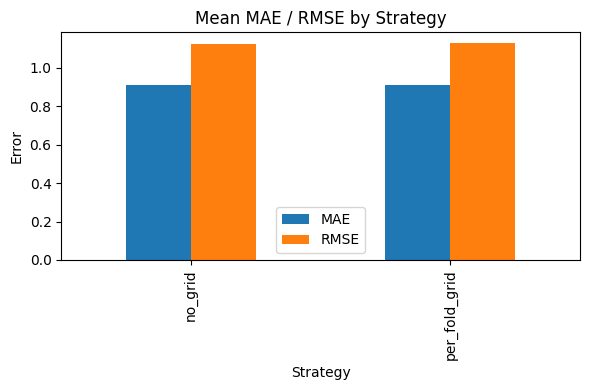

In [7]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,4))
means = summary.xs('mean', level=1, axis=1)
means.plot(kind='bar', ax=ax)
ax.set_title('Mean MAE / RMSE by Strategy')
ax.set_ylabel('Error')
ax.set_xlabel('Strategy')
ax.legend(loc='best')
plt.tight_layout()
plt.show()


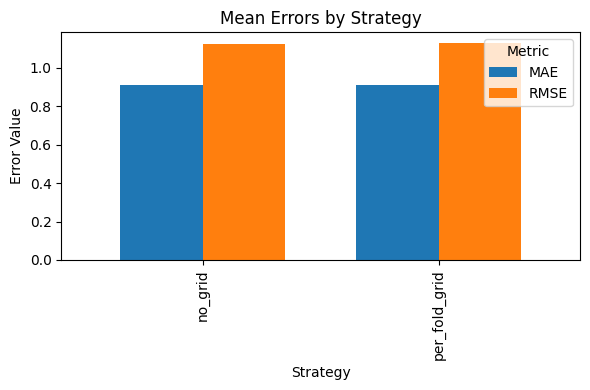

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,4))

# ดึงค่า mean MAE และ RMSE ออกมา
means = summary.xs('mean', level=1, axis=1)

# สร้างกราฟแท่งแบบ side-by-side
means.plot(kind='bar', ax=ax, width=0.7)

ax.set_title('Mean Errors by Strategy')
ax.set_ylabel('Error Value')
ax.set_xlabel('Strategy')
ax.legend(title='Metric', loc='best')
plt.tight_layout()
plt.show()


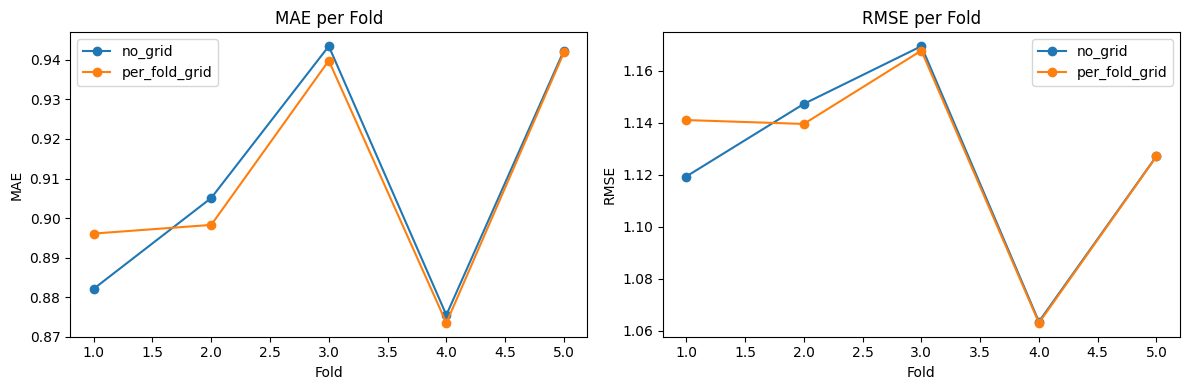

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12,4), sharex=True)

for metric, axis in zip(['MAE','RMSE'], ax):
    for strat in compare_df['strategy'].unique():
        sub = compare_df[compare_df['strategy']==strat]
        axis.plot(sub['fold'], sub[metric], marker='o', label=strat)
    axis.set_title(f'{metric} per Fold')
    axis.set_xlabel('Fold')
    axis.set_ylabel(metric)
    axis.legend()

plt.tight_layout()
plt.show()



## Using your own dataset and model

Replace the synthetic data section with your own `X` (as a `pd.DataFrame`) and `y` (as a `pd.Series`) aligned by time index.  
You may also swap `Ridge()` for any other estimator (e.g., `RandomForestRegressor`, `SVR`) and adjust `param_grid` accordingly.

**Important:** Keep `TimeSeriesSplit` for both outer and inner folds to respect temporal ordering.
